In [1]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Banana/Banana.exe", no_graphics=True)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

info = env.reset(train_mode=True)[brain_name]
state = info.vector_observations[0]
n_actions = brain.vector_action_space_size
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([random.sample(range(0,4), 1)], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.axhline(y=13, color='r')
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    current_batch = batch.action
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [8]:
config = torch.load("model.pth", map_location=torch.device("cpu").type)
policy_net.load_state_dict(config["policy_net_state_dict"])
policy_net.to(device)
optimizer.load_state_dict(config["optimizer_state_dict"])
BATCH_SIZE = config["batch_size"]
GAMMA = config["gamma"]
EPS_START = config["eps_start"]
EPS_END = config["eps_end"]
EPS_DECAY = config["eps_decay"]
TAU = config["tau"]
episode_durations = config["episode_rewards"]
memory = config["memory"]
LR = config["lr"]
steps_done = config["steps_done"]
target_net.load_state_dict(policy_net.state_dict())
target_net.to(device)

DQN(
  (layer1): Linear(in_features=37, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

Complete


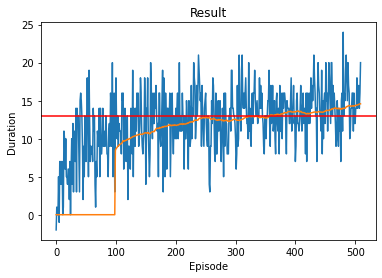

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
try:
    for _ in range(50):
        episode_reward = 0
        info = env.reset(train_mode=True)[brain_name]
        state = info.vector_observations[0]
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
            action = select_action(state)
            info = env.step(int(action))[brain_name]
            next_state = info.vector_observations[0]
            reward = info.rewards[0]
            done = info.local_done[0]
            reward = torch.tensor([reward], device=device)
            episode_reward += reward
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

            memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model()

            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(episode_reward)
                plot_durations()
                break
finally:
    torch.save({
                'policy_net_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'batch_size': BATCH_SIZE,
                'gamma': GAMMA,
                'eps_start': EPS_START,
                'eps_end': EPS_END,
                'eps_decay': EPS_DECAY,
                'tau': TAU,
                'episode_rewards': episode_durations,
                'memory': memory,
                'steps_done': steps_done,
                'lr': LR
            }, "model.pth")
    print('Complete')
    plot_durations(show_result=True)
    plt.ioff()
    plt.show()

In [12]:
env.close()